# Auswertung der Gesamtsysteme
## Data Import & Processing

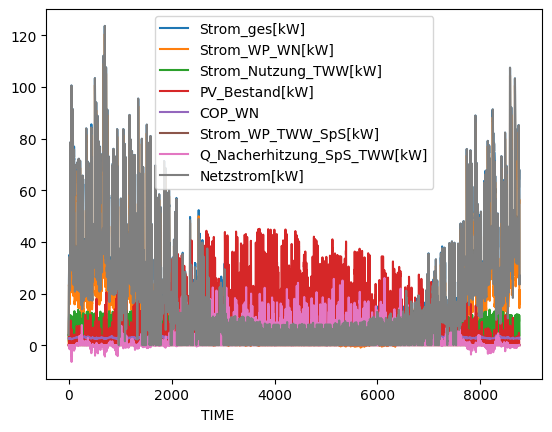

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

systems={} # anlegen dictionnaire
system_names=["Bestand", "dezentral", "NT-WN", "kalte_NW"]  #define list system names
 

# define paths
paths = {"NT-WN": r"C:\Users\lbarnic\OneDrive - Fraunhofer\A_Bearbeitung\7_Gesamtsysteme_REP\II_HT_WN\NT_WN_Output.out"} # später weitere Pfade einfügen

# data import function
def import_data(path):
    # system = pd.read_csv(path)
    system = pd.read_csv(path, sep=',', skipinitialspace=True, index_col=0)
    system = system.drop(system.columns[-1], axis=1)
    system.columns = ["Strom_ges[kW]", "Strom_WP_WN[kW]", "Strom_Nutzung_TWW[kW]", "PV_Bestand[kW]", "COP_WN","Strom_WP_TWW_SpS[kW]","Q_Nacherhitzung_SpS_TWW[kW]"]
    return system
#plot system data

def plot_system(system):
    system.plot()
    plt.show()


# import results for each path  
for name, path in paths.items():    # define paths
    df = import_data(path)   
    systems[name] = df              # df ablegen unter zugehörigem name
    systems[name]["Netzstrom[kW]"] = systems[name]["Strom_ges[kW]"] - systems[name]["PV_Bestand[kW]"] # calculate Netzstrom in new column as difference from Strom_ges and PV
    #replace every value below 0 with 0 in Netzstrom
    systems[name]["Netzstrom[kW]"] = systems[name]["Netzstrom[kW]"].clip(lower=0)

#plot data systems
for name, system in systems.items():
    plot_system(system)
# Idee: FUnktionen zur Auswertung definieren und über loop für alle 4 durchlaufen lassen. Betrachten von einem Jahr in Betrieb.



___
## Ökologische Nachhaltigkeit
### CO2-Emissionen im Betrieb
#### define functions + values



In [ ]:
# Define the dictionary with Emissionsfaktoren (Quelle: Technikkatalog)
# Werte = t CO2-Äquivalent pro MWh Endenergie
emissionsfaktoren_waerme = {
    "Heizöl": {"2020": 0.318, "2021": 0.311, "2030": 0.311, "2040": 0.311},
    "Erdgas": {"2020": 0.247, "2021": 0.233, "2030": 0.233, "2040": 0.233},
    "Braunkohle": {"2020": 0.411, "2021": 0.473, "2030": 0.473, "2040": 0.473},
    "Steinkohle": {"2020": 0.438, "2021": 0.431, "2030": 0.431, "2040": 0.431},
    "Abfall": {"2020": 0.121, "2021": 0.121, "2030": 0.121, "2040": 0.121},
    "Holz": {"2020": 0.022, "2021": 0.022, "2030": 0.022, "2040": 0.022},
    "Biogas": {"2020": 0.090, "2021": 0.090, "2030": 0.086, "2040": 0.081},
    "Synthetisches Methan": {"2020": None, "2021": None, "2030": 0.041, "2040": 0.036},
    "Synthetisches Methanol": {"2020": None, "2021": None, "2030": 0.048, "2040": 0.044},
    "Elektrische Wärmepumpe": {"2020": 0.137, "2021": 0.029, "2030": 0.028, "2040": 0.028},
    "Stromdirektheizung": {"2020": 0.438, "2021": 0.057, "2030": 0.056, "2040": 0.054},
    "Solarthermie": {"2020": 0.025, "2021": 0.013, "2030": 0.013, "2040": 0.013},
    "Tiefe Geothermie": {"2020": None, "2021": None, "2030": 0.036, "2040": 0.025},
    "Abwärme aus Prozessen": {"2020": None, "2021": None, "2030": 0.040, "2040": 0.038},
    "Wärmenetz aus KWK (Stein-/Braunkohle)": {"2020": 0.260, "2021": 0.300, "2030": 0.300, "2040": 0.300},
    "Wärmenetz aus KWK (Gasförmiger und flüssiger Brennstoff)": {"2020": 0.260, "2021": 0.180, "2030": 0.171, "2040": 0.171},
    "Wärmenetz aus KWK (Erneuerbarer Brennstoff)": {"2020": 0.260, "2021": 0.040, "2030": 0.039, "2040": 0.038},
    "Wärmenetz aus Heizwerk (Stein-/Braunkohle)": {"2020": 0.260, "2021": 0.400, "2030": 0.400, "2040": 0.400},
    "Wärmenetz aus Heizwerk (Gasförmiger und flüssiger Brennstoff)": {"2020": 0.260, "2021": 0.300, "2030": 0.300, "2040": 0.300},
    "Wärmenetz aus Heizwerk (Erneuerbarer Brennstoff)": {"2020": 0.260, "2021": 0.060, "2030": 0.042, "2040": 0.024},
    "Wärmenetzleitungen": {"2020": None, "2021": None, "2030": 0.043, "2040": 0.042}
}

emissionsfaktoren_strom = {
    "Wasserkraft": {"2020": 0.003, "2021": 0.003, "2030": 0.003, "2040": 0.003},
    "Windkraft": {"2020": 0.010, "2021": 0.010, "2030": 0.009, "2040": 0.008},
    "Fotovoltaik": {"2020": 0.040, "2021": 0.040, "2030": 0.035, "2040": 0.030},
    "Geothermie": {"2020": 0.089, "2021": 0.089, "2030": 0.080, "2040": 0.071},
    "Festbrennstoffe, Holz": {"2020": 0.025, "2021": 0.025, "2030": 0.025, "2040": 0.025},
    "Flüssige Biomasse": {"2020": 0.116, "2021": 0.116, "2030": 0.113, "2040": 0.110},
    "Biogas (Stromerzeugung)": {"2020": 0.097, "2021": 0.097, "2030": 0.092, "2040": 0.087},
    "Synthetisches Methan (Stromerzeugung)": {"2020": None, "2021": None, "2030": 0.041, "2040": 0.036},
    "Klärgas/Deponiegas": {"2020": 0.051, "2021": 0.051, "2030": 0.048, "2040": 0.046},
    "Wasserstoff": {"2020": None, "2021": None, "2030": 0.050, "2040": 0.035},
    "Strom-Mix-D (UBA)": {"2020": None, "2021": None, "2030": 0.485, "2040": None},
    "Strom-Mix-D (IINAS Szenario)": {"2020": 0.438, "2021": None, "2030": 0.270, "2040": 0.032}
}

# Given data to calculate CO2e
year = 2020  # Example year

# Function to calculate CO2e
def calculate_co2e(df, emissionsfaktoren, year):
    co2e = df["Netzstrom[kW]"] * emissionsfaktoren["Strom-Mix-D (UBA)"][str(year)] / 1000  # Convert kW to MW
    return co2e

# Calculate CO2e for the given dataframe and year
df["CO2e"] = calculate_co2e(df, emissionsfaktoren, year)

# given data to calculate CO2e



# function to calculate CO2e
calculateco2e=





SyntaxError: invalid syntax (639146051.py, line 54)

#### use functions

### Primärenergiebedarf
#### Randbedingungen

In [ ]:
# Tabelle PEF
PEF = {
    "Nummer": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    "Kategorie": [
        "Fossile Brennstoffe", "Fossile Brennstoffe", "Fossile Brennstoffe", "Fossile Brennstoffe", "Fossile Brennstoffe",
        "Biogene Brennstoffe", "Biogene Brennstoffe", "Biogene Brennstoffe", "Strom", "Strom", "Strom",
        "Wärme, Kälte", "Wärme, Kälte", "Wärme, Kälte", "Wärme, Kälte", "Siedlungsabfälle"
    ],
    "Energieträger": [
        "Heizöl", "Erdgas", "Flüssiggas", "Steinkohle", "Braunkohle", "Biogas", "Bioöl", "Holz", "netzbezogen",
        "gebäudenah erzeugt (aus Photovoltaik oder Windkraft)", "Verdrängungsstrommix für KWK", "Erdwärme, Geothermie, Solarthermie, Umgebungswärme",
        "Erdkälte, Umgebungskälte", "Abwärme", "Wärme aus KWK, gebäudeintegriert oder gebäudenah", ""
    ],
    "Primärenergiefaktoren nicht erneuerbarer Anteil": [
        1.1, 1.1, 1.1, 1.1, 1.2, 1.1, 1.1, 0.2, 1.8, 0.0, 2.8, 0.0, 0.0, 0.0, "nach Verfahren B gemäß DIN V 18599-9: 2018-09 Abschnitt 5.2.5 oder DIN V 18599-9: 2018-09 Abschnitt 5.3.5.1", 0.0
    ]
}

# DataFrame erstellen
df_PEF = pd.DataFrame(PEF)

# DataFrame anzeigen
display(df_PEF)

___
## Ökonomische Bewertung
